**AutoRec Project**

# Imports

In [1]:
%matplotlib inline

In [2]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.5 MB/s 


In [3]:
from google.colab import drive
import os

# keras
from tensorflow.keras.models import load_model
import tensorflow as tf
import keras_tuner as kt

# sklearn
from sklearn.model_selection import train_test_split

import sys
import requests
import zipfile
import copy
import shutil

import pandas as pd
import numpy as np
import random
import math

from matplotlib import pyplot as plt

In [4]:
np.random.seed(123)
random.seed(123)

In [5]:
!git clone https://github.com/aviadar/RecSys_AutoRecProject proj

Cloning into 'proj'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 89 (delta 33), reused 65 (delta 16), pack-reused 0
Unpacking objects: 100% (89/89), done.


In [6]:
sys.path.insert(0,'/content/proj/src')

from utilities.Metrics import Metrics
from models.MF import MF
from models.IAutoRec import IAutoRec
from models.IAutoRecEnhanced import IAutoRecEnhanced

# MovieLens 1M Dataset

## Data Loading & Manipulation

In [7]:
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
zip_name = 'ml-1m.zip'
data_dir = 'ml-1m/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

In [8]:
ratings_df = pd.read_csv('/content/ml-1m/ratings.dat', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], delimiter='::')
ratings_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


we are not intrested in timestamps, so we can remove the column. <br>
also, in order to keep embedding size as small as possible, we need to change the user and item ids.

In [9]:
ratings_df.drop(columns='timestamp', inplace=True)

def user_id_trans(idx):
    return idx-1

item_id_trans_dict =  {k:v for k,v in zip(ratings_df.item_id.unique(),range(ratings_df.item_id.nunique()))}
def item_id_trans(key_value):
    return item_id_trans_dict[key_value]

ratings_df.user_id = ratings_df.user_id.apply(user_id_trans)
ratings_df.item_id = ratings_df.item_id.apply(item_id_trans)

ratings_df.head()

,user_id,item_id,rating
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


In [10]:
ml_users_num, ml_items_num = ratings_df.user_id.nunique(), ratings_df.item_id.nunique()
ml_users_num, ml_items_num

(6040, 3706)

## Train\Test Split

splitting the data into train, validation and test:

In [11]:
train, test = train_test_split(ratings_df, test_size=0.1, random_state=999613182)
train.user_id.nunique(), train.item_id.nunique()

def create_full_mat(df):
    full_mat = np.zeros((ml_users_num, ml_items_num))
    for user, item, rating in zip(df.user_id, df.item_id, df.rating):
        full_mat[user, item] = rating
    return full_mat

full_train_mat = create_full_mat(train)
full_test_mat = create_full_mat(test)

In [12]:
def df_to_mat(df):
    full_mat = np.zeros((df.user_id.max()+1, df.item_id.max()+1))
    for user, item, rating in zip(df.user_id, df.item_id, df.rating):
        full_mat[user, item] = rating
    return full_mat

## Matrix Factorization

### Hyperparameter Tuning

creating and fitting the model:

In [13]:
mf = MF(users_num=ratings_df.user_id.max()+1, items_num=ratings_df.item_id.max()+1)

In [14]:
tuner = kt.Hyperband(mf.model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hyper_params',
                     project_name='mf_ml')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        60400       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        37060       ['item_input[0][0]']             
                                                                                              

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search([np.array(train.user_id), np.array(train.item_id)], np.array(train.rating), 
             epochs=10, validation_split=0.2, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 8 Complete [00h 00m 12s]
val_loss: 0.8660721182823181

Best val_loss So Far: 0.8660721182823181
Total elapsed time: 00h 01m 53s
INFO:tensorflow:Oracle triggered exit


In [16]:
best_hps.get('latent_dim'), best_hps.get('learning_rate')

(40, 0.001)

### Retraining

In [17]:
mf_opt = MF(users_num=ratings_df.user_id.max()+1, items_num=ratings_df.item_id.max()+1, latent_dim=best_hps.get('latent_dim'), learning_rate=best_hps.get('learning_rate'))
mf_opt.build_opt_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 40)        241600      ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 40)        148240      ['item_input[0][0]']             
                                                                                            

In [18]:
mf_opt.fit(train.user_id, train.item_id, labels=train.rating)

Epoch 1/100
1583/1583 [==============================] - 7s 4ms/step - loss: 6.0367 - val_loss: 1.0813
Epoch 2/100
1583/1583 [==============================] - 6s 4ms/step - loss: 0.9202 - val_loss: 0.8610
Epoch 3/100
1583/1583 [==============================] - 6s 4ms/step - loss: 0.8360 - val_loss: 0.8283
Epoch 4/100
1583/1583 [==============================] - 6s 4ms/step - loss: 0.8031 - val_loss: 0.8051
Epoch 5/100
1583/1583 [==============================] - 6s 4ms/step - loss: 0.7755 - val_loss: 0.7881
Epoch 6/100
1583/1583 [==============================] - 6s 4ms/step - loss: 0.7517 - val_loss: 0.7763
Epoch 7/100
1583/1583 [==============================] - 6s 4ms/step - loss: 0.7302 - val_loss: 0.7675
Epoch 8/100
1583/1583 [==============================] - 6s 4ms/step - loss: 0.7084 - val_loss: 0.7602
Epoch 9/100
1583/1583 [==============================] - 6s 4ms/step - loss: 0.6850 - val_loss: 0.7513
Epoch 10/100
1583/1583 [==============================] - 6s 4ms/step - l

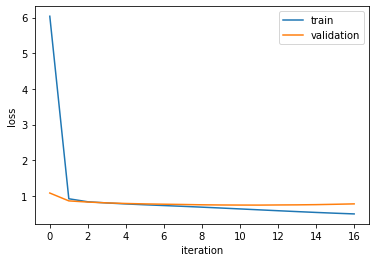

In [19]:
# plot training history
plt.plot(mf_opt.hist.history['loss'], label='train')
plt.plot(mf_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
mf_opt.model = load_model('best_mf_model.h5')

In [21]:
shutil.rmtree('/content/hyper_params')

### Prediction

test prediction:

In [22]:
mf_opt.predict(test.user_id, test.item_id)

13/13 [==============================] - 0s 3ms/step


### Evaluation

In [23]:
pred_df = test.copy()
pred_df.rating = mf_opt.predictions.reshape(-1)
pred_mat = df_to_mat(pred_df)
test_mat = df_to_mat(test)

In [24]:
mf_opt_eval = Metrics.get_evaluation(test_mat, pred_mat)
mf_opt_eval

{'MRR_10': 0.9769878574226399,
 'MRR_5': 0.9769878574226399,
 'NDCG_10': 0.9669656816103274,
 'NDCG_100': 0.9716927966699688,
 'NDCG_5': 0.9714578253670941,
 'RMSE': 0.8589624058098179}

Text(0, 0.5, 'values')

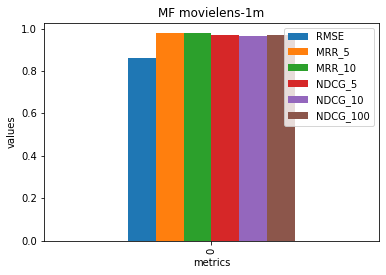

In [25]:
mf_opt_eval_df = pd.DataFrame(mf_opt_eval, index=[0])
mf_opt_eval_df.plot(kind='bar')
plt.title('MF movielens-1m')
plt.xlabel('metrics')
plt.ylabel('values')

Note that we approximately reached the RMSE described in the paper (0.86 vs. 0.845). Furthermore our implementation uses regular MF where as the paper comparison is Biased-MF based.

## AutoRec

### Data Manipulation

In [26]:
def dataPreprocessor(rating_df):
    # train_df, test_df = train_test_split(rating_df, test_size=0.1, random_state=42)
    train_df, test_df = train_test_split(rating_df, test_size=0.1, random_state=999613182)
    train_mat = np.zeros((rating_df.user_id.nunique(), rating_df.item_id.nunique()))
    for (user_id, item_id, rating) in zip(train_df.user_id, train_df.item_id, train_df.rating):
        train_mat[user_id, item_id] = rating

    ## tmp ##
    # train_mat_avg = copy.copy(train_mat)
    # avg = np.true_divide(train_mat_avg.sum(1), np.maximum((train_mat_avg!=0).sum(1), 1))
    # inds = np.where(train_mat_avg == 0)
    # train_mat_avg[inds] = np.take(avg, inds[0])

    test_mat = np.zeros((rating_df.user_id.nunique(), rating_df.item_id.nunique()))
    for (user_id, item_id, rating) in zip(test_df.user_id, test_df.item_id, test_df.rating):
        test_mat[user_id, item_id] = rating
    
    return train_mat, test_mat #, train_mat_avg

### Hyperparameters Tuning

In [27]:
train_mat, test_mat = dataPreprocessor(ratings_df)
autorec = IAutoRec(train_mat.shape[1])
tuner = kt.Hyperband(autorec.model_builder,
                    #  objective='val_loss',
                     objective='loss',
                     max_epochs=500,
                     directory='hyper_params',
                     project_name='autorec_ml')


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 latent_dim (Dense)          (None, 200)               741400    
                                                                 
 item_pred_rating (Dense)    (None, 3706)              744906    
                                                                 
Total params: 1,486,306
Trainable params: 1,486,306
Non-trainable params: 0
_________________________________________________________________


In [28]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(train_mat, train_mat,
             epochs=500, validation_split=0.1, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 52 Complete [00h 00m 03s]
loss: 4.630521774291992

Best loss So Far: 1.1757464408874512
Total elapsed time: 00h 01m 46s
INFO:tensorflow:Oracle triggered exit


In [29]:
best_hps.get('hidden_units'), best_hps.get('first_activation'), best_hps.get('last_activation') ,best_hps.get('reg'), best_hps.get('learning_rate')

(400, 'sigmoid', 'elu', 0.0001, 0.001)

### Retraining

In [30]:
autorec_opt = IAutoRec(train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), reg=best_hps.get('reg'), 
                       learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                       last_activation=best_hps.get('last_activation'))
autorec_opt.build_opt_model()
autorec_opt.fit(train_mat, train_mat)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 latent_dim (Dense)          (None, 400)               1482800   
                                                                 
 item_pred_rating (Dense)    (None, 3706)              1486106   
                                                                 
Total params: 2,968,906
Trainable params: 2,968,906
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
22/22 - 1s - loss: 1.9525 - val_loss: 1.2200 - 812ms/epoch - 37ms/step
Epoch 2/500
22/22 - 0s - loss: 1.1551 - val_loss: 1.1268 - 207ms/epoch - 9ms/step
Epoch 3/500
22/22 - 0s - loss: 1.0987 - val_loss: 1.0999 - 200ms/epoch - 9ms/step
Epoch 4/500
22/22 - 0s - loss: 1.0795 - val_loss: 1.0860 - 208ms/e

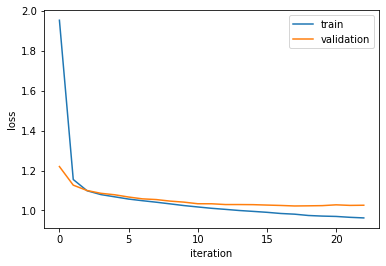

In [31]:
# plot training history
plt.plot(autorec_opt.hist.history['loss'], label='train')
plt.plot(autorec_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [32]:
autorec_opt.model = load_model('best_autorec_model.h5', custom_objects={'masked_rmse': IAutoRec.masked_rmse})


In [33]:
shutil.rmtree('/content/hyper_params')

### Prediction

In [34]:
# autorec.predict(np.zeros(test_mat.shape))
autorec_opt.predict(test_mat)

12/12 [==============================] - 0s 3ms/step


### Evaluation

In [35]:
autorec_opt_eval = Metrics.get_evaluation(test_mat, autorec_opt.predictions)
autorec_opt_eval

{'MRR_10': 0.9705164792121314,
 'MRR_5': 0.9704885009232833,
 'NDCG_10': 0.9598457597597271,
 'NDCG_100': 0.9632862472621129,
 'NDCG_5': 0.966159332557079,
 'RMSE': 1.22719955150456}

Text(0, 0.5, 'values')

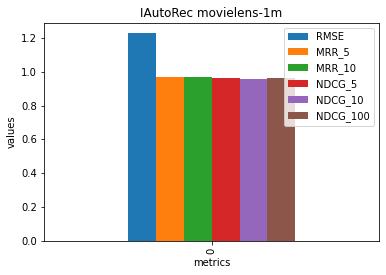

In [36]:
autorec_opt_eval_df = pd.DataFrame(autorec_opt_eval, index=[0])
autorec_opt_eval_df.plot(kind='bar')
plt.title('IAutoRec movielens-1m')
plt.xlabel('metrics')
plt.ylabel('values')

Note that we did not acheive similar results as the paper. our model's RMSE reaches 1.2 while the paper's reches 0.831. <br> This is quite a big difference, the reasons colud be explained by getting different hyperparameters. 
The paper does not disclose all of the hyperparameters.
It describes some of them, such as regularization, hidden layer size and activation functions. Other parameters such as learning rate are not available, furthermore they use a different train and evaluation mechanism: "We repeat this splitting procedure 5 times and report average RMSE."

## IAutoRec Enhanced

### HyperParameters Tuning

In [37]:
autorec_enhanced = IAutoRecEnhanced(train_mat.shape[1])
tuner = kt.Hyperband(autorec_enhanced.model_builder,
                     objective='val_loss',
                    #  objective='loss',
                     max_epochs=500,
                    #  factor=3,
                     directory='hyper_params',
                     project_name='autorec_enhanced_ml')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 hidden_encoder (Dense)      (None, 200)               741400    
                                                                 
 latent_dim (Dense)          (None, 100)               20100     
                                                                 
 hidden_decoder (Dense)      (None, 200)               20200     
                                                                 
 item_pred_rating (Dense)    (None, 3706)              744906    
                                                                 
Total params: 1,526,606
Trainable params: 1,526,606
Non-trainable params: 0
_________________________________________________________________


In [38]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(train_mat, train_mat,
             epochs=500, validation_split=0.1, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 100 Complete [00h 00m 01s]
val_loss: 2.233543634414673

Best val_loss So Far: 1.1061586141586304
Total elapsed time: 00h 04m 00s
INFO:tensorflow:Oracle triggered exit


In [39]:
best_hps.get('hidden_units'), best_hps.get('hidden_layer_factor'), best_hps.get('first_activation'), best_hps.get('last_activation'), best_hps.get('reg'), best_hps.get('learning_rate')

(100, 2, 'elu', 'elu', 0.0001, 0.001)

### Retraining

In [40]:
autorec_enhanced_opt = IAutoRecEnhanced(train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), 
                                        hidden_layer_factor=best_hps.get('hidden_layer_factor'), reg=best_hps.get('reg'), 
                                        learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                                        last_activation=best_hps.get('last_activation'))
autorec_enhanced_opt.build_opt_model()
autorec_enhanced_opt.fit(train_mat, train_mat)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 3706)]            0         
                                                                 
 hidden_encoder (Dense)      (None, 200)               741400    
                                                                 
 latent_dim (Dense)          (None, 100)               20100     
                                                                 
 hidden_decoder (Dense)      (None, 200)               20200     
                                                                 
 item_pred_rating (Dense)    (None, 3706)              744906    
                                                                 
Total params: 1,526,606
Trainable params: 1,526,606
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
22/22 - 1s - loss: 2.2166 - val_loss:

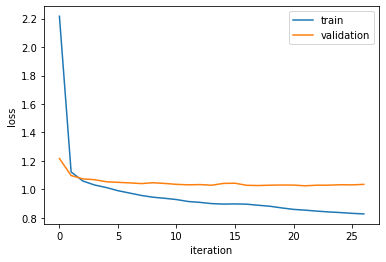

In [41]:
# plot training history
plt.plot(autorec_enhanced_opt.hist.history['loss'], label='train')
plt.plot(autorec_enhanced_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [42]:
autorec_enhanced_opt.model = load_model('best_autorec_enhanced_model.h5', custom_objects={'masked_rmse': IAutoRecEnhanced.masked_rmse})

In [43]:
shutil.rmtree('/content/hyper_params')

### Prediction

In [44]:
autorec_enhanced_opt.predict(test_mat)

12/12 [==============================] - 0s 3ms/step


### Evaluation

In [45]:
autorec_enhanced_opt_eval = Metrics.get_evaluation(test_mat, autorec_enhanced_opt.predictions)
autorec_enhanced_opt_eval

{'MRR_10': 0.9745637385388939,
 'MRR_5': 0.9745397571484529,
 'NDCG_10': 0.9614263209309873,
 'NDCG_100': 0.9622822093063655,
 'NDCG_5': 0.9681381379028964,
 'RMSE': 1.2540092015790152}

Text(0, 0.5, 'values')

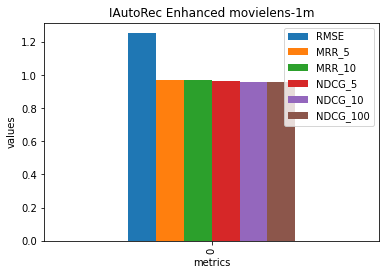

In [46]:
autorec_enhanced_opt_eval_df = pd.DataFrame(autorec_enhanced_opt_eval, index=[0])
autorec_enhanced_opt_eval_df.plot(kind='bar')
plt.title('IAutoRec Enhanced movielens-1m')
plt.xlabel('metrics')
plt.ylabel('values')

## Models Metrics Comparison

In [47]:
result_dict = {
    'mf': mf_opt_eval,
    'autorec': autorec_opt_eval,
    'autorec_enhanced': autorec_enhanced_opt_eval
               }
res_df = pd.DataFrame.from_dict(result_dict)
res_df

,mf,autorec,autorec_enhanced
RMSE,0.858962,1.227200,1.254009
MRR_5,0.976988,0.970489,0.974540
MRR_10,0.976988,0.970516,0.974564
NDCG_5,0.971458,0.966159,0.968138
NDCG_10,0.966966,0.959846,0.961426
NDCG_100,0.971693,0.963286,0.962282


Text(0.5, 1.0, 'movielens-1m models results')

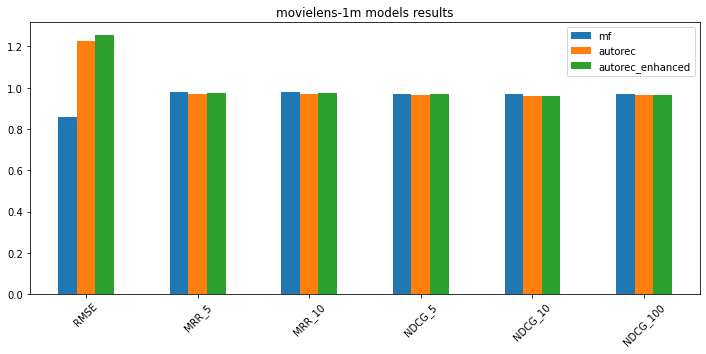

In [48]:
res_df.plot(kind='bar', figsize=(12,5), rot=45)
plt.title('movielens-1m models results')

Text(0.5, 1.0, 'movielens-1m models results')

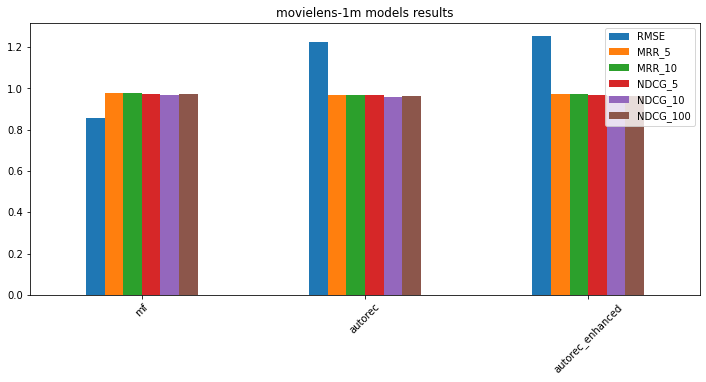

In [49]:
res_df.transpose().plot(kind='bar', figsize=(12,5), rot=45)
plt.title('movielens-1m models results')